# Functions

This module collects miscellaneous functions that I found myself using somewhat frequently across my work. There are 5 packages within this module:

- Kepler_solver
    1. get_E
    1. get_E_niter
    1. get_f
    1. get_f_niter
- orbits
    1. PtoA
    1. AtoP
- pdfs
    1. double_Rayleigh_pdf
- stats_fitting
    1. find_best_continuous_dist_warnings
    1. find_best_continuous_dist
- LL_secular
    1. A_jj
    1. A_jk
    1. B_jj
    1. B_jk
    1. A_matrix
    1. B_matrix
    1. g_eigenfreqs
    1. f_eigenfreqs
    1. A
    1. A_j
    1. B
    1. B_j
    1. max_forced_e
    1. max_inner_e
    1. max_e_3planets
    1. e_tmax_3planets
    1. max_forced_i

## Kepler_solver

This package solves Kepler's equation numerically (using Newton's method, see e.g. Murray & Correia 2011 eqns 42/43) for the eccentric anomaly (E) given an eccentricity (e) and a mean anomaly (M). It also can use E to calculate the true anomaly (f). These functions exist in other packages (like $\texttt{REBOUND}$), but at some point I wanted to just use my own, so now they exist here.

$M = E - e \text{sin} E$

$f = 2 \text{arctan} (\sqrt{\frac{1+e}{1-e}} \text{tan}\frac{E}{2})$

In [1]:
import Kepler_solver

import numpy as np

In [2]:
M = 1.5
e = .3

In [3]:
#get_E iterates until converged, with a change of <1e-12 being the converge criteria.
E1 = Kepler_solver.get_E(e,M)
print(E1)

#check that Kepler's equation is solved
print(M,E1 - e*np.sin(E1),'\n')

1.7926475365684045
1.5 1.5 



In [4]:
#get_E_niter iterates for a given number of steps and returns E and the change between the last iterations.
E2,tol2 = Kepler_solver.get_E_niter(e,M,2)
E3,tol3 = Kepler_solver.get_E_niter(e,M,3)
E4,tol4 = Kepler_solver.get_E_niter(e,M,4)
E5,tol5 = Kepler_solver.get_E_niter(e,M,5)
print(E2,tol2)
print(E3,tol3)
print(E4,tol4)
print(E5,tol5)

#check that Kepler's equation is solved
print(M,E5 - e*np.sin(E5))

1.7926709216825938 0.013065659355651293
1.7926475366434678 2.3385039126022633e-05
1.7926475365684045 7.506328891793146e-11
1.7926475365684045 0.0
1.5 1.5


In [5]:
#get_f finds f using the get_E function.
f1 = Kepler_solver.get_f(e,M)
print(f1)

2.0804025904657064


In [6]:
#get_f_niter finds f using the get_E_niter function.
f2,tol2 = Kepler_solver.get_f_niter(e,M,2)
f3,tol3 = Kepler_solver.get_f_niter(e,M,3)
f4,tol4 = Kepler_solver.get_f_niter(e,M,4)
f5,tol5 = Kepler_solver.get_f_niter(e,M,5)
print(f2,tol2)
print(f3,tol3)
print(f4,tol4)
print(f5,tol5)

2.0804235169953054 0.013065659355651293
2.080402590532878 2.3385039126022633e-05
2.0804025904657064 7.506328891793146e-11
2.0804025904657064 0.0


## orbits

This package contains two functions that convert between period (P) and semi-major axis (a) using Kepler's Third Law. It includes units via the astropy package. Any units can be used for the input arrays, but the outputs are always returned with AU (for a) or days (for P). The arrays can be in any order, but the stellar mass must be the first entry in the mass array and the planets must be in the same order for each array.

$a^3 = \frac{P^2 G (M_\star + m_p)}{4 \pi^2}$

In [7]:
import orbits

import numpy as np
import astropy.units as u

In [8]:
masses = np.array([1*u.Msun/u.Mjupiter,1*u.Mearth/u.Mjupiter,.5,1])*u.Mjupiter
print(masses)

[1.04756551e+03 3.14635187e-03 5.00000000e-01 1.00000000e+00] jupiterMass


In [9]:
#PtoA takes an array of N+1 masses and an array of N periods and returns an array of N semi-major axes.
#for N planets.

periods = np.array([1,30,11])*u.year
smas = orbits.PtoA(masses,periods)
print(smas)

[0.99998841 9.6563081  4.94759848] AU


In [10]:
#AtoP takes an array of N+1 masses and an array of N semi-major axes and returns an array of N periods.
#for N planets.

smas = np.array([1,9.5,5])*u.AU
periods = orbits.AtoP(masses,smas)
print(periods)
print(periods.to(u.yr))

[  365.25634986 10692.52355971  4081.7485281 ] d
[ 1.00001738 29.27453404 11.17521842] yr


## pdfs

Despite the name, this package in fact contains only a single pdf. The pdf is for the resulting pdf as a function of $x$ when you add together two independent Rayleigh distributions with the same scale ($\sigma$). This is calculated based on the fact that the probability distribution of the sum of two independent random variables is the convolution of their individual distributions.

$P(x,\sigma) = \frac{e^{-x^2/2\sigma^2}}{4\sigma^3}\left (2\sigma x - e^{x^2/4\sigma^2}\sqrt{\pi}(2\sigma^2-x^2) \text{erf}(\frac{x}{2\sigma}) \right )$

In [11]:
import pdfs

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

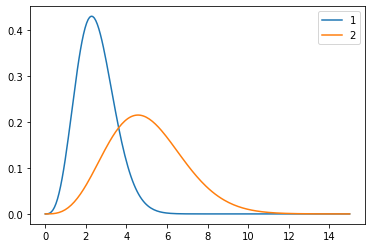

In [12]:
x = np.linspace(0,15,200)
pdf1 = pdfs.double_Rayleigh_pdf(x,1)
pdf2 = pdfs.double_Rayleigh_pdf(x,2)

plt.plot(x,pdf1,label='1')
plt.plot(x,pdf2,label='2')
plt.legend()

## stats_fitting

This package cycles through all of the continuous variable distributions built into the $\texttt{SciPy}$ stats module and finds the three distributions that can best fit a dataset (using the highest p-values from a 2-sided Kolmogorov-Smirnov test). Useful when you want to approximate a dataset without having a physical motivation for choosing a certain distribution, but it can be very slow, especially for large datasets. There is a hardcoded timeout that is set to 5 seconds for each distribution to offset this.

Given the way p-values are calculated, there is randomness in the process so it won't always return the exact same thing. Also when used on a known distribution, it doesn't always return the correct one as several may be able to approximate the data quite well.

In [13]:
import stats_fitting

import numpy as np
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt

(array([0.09238822, 0.09168296, 0.0789884 , 0.19253422, 0.08039891,
        0.08392517, 0.05853605, 0.0197471 , 0.00564203, 0.00141051]),
 array([ 0.10090319,  1.51883291,  2.93676264,  4.35469237,  5.7726221 ,
         7.19055183,  8.60848155, 10.02641128, 11.44434101, 12.86227074,
        14.28020047]),
 <BarContainer object of 10 artists>)

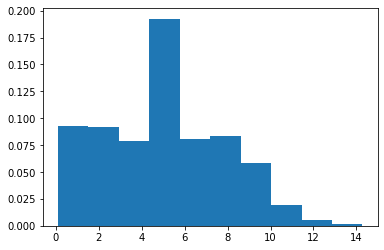

In [14]:
N = 1000

#create a single dataset from a known distribution
data_norm = stats.norm.rvs(3,.1,N)

#create a dataset without a corresponding single distribution
data1 = stats.uniform.rvs(0,10,N)
data2 = stats.semicircular.rvs(5,1,N)
data3 = stats.genexpon.rvs(4,1,2,1,5,N)
data4 = stats.norm.rvs(8,2,N)
data_combined = np.random.choice(np.concatenate((data1,data2,data3,data4)),N,replace=False)

plt.hist(data_combined,density=True)

In [15]:
#this approach can raise a lot of spurious warnings, so there is an included wrapper function that ignores warnings.
#run find_best_continuous_dist_warnings to run with warnings on.
#can also choose to print outputs during the process or not.
#if printing=True, it will print each distro and its p-value and then the final top-3 distributions/p-values.
#if printing=False, it will just return the names of the top 3 distributions as an array.

distros = stats_fitting.find_best_continuous_dist(data_norm,printing=True)

alpha 0.11677281598391237
anglit 4.457569108035107e-08
arcsine 3.2557636492777553e-40
argus 2.3835996925264847e-35
beta 0.5654378910227662
betaprime 0.11677281598391372
bradford 1.4298785797270848e-30
burr 0.3631989538416788
burr12 0.14408243524623562
cauchy 0.006772552391238013
chi 0.8547289084783269
chi2 6.883804887735039e-74
cosine 0.0
crystalball 0.36319895384167805
dgamma 0.6785103823828913
dweibull 0.8547289084783269
erlang 0.4253468503964972
expon 1.0381186991729691e-49
exponnorm 0.6406050184621188
exponweib 0.6028025867269027
exponpow 0.014097547738750642
f 0.9328249603675505
fatiguelife 0.9101088695418414
fisk 0.5287957655456487
foldcauchy 9.92700626378619e-05
foldnorm 2.666952933664275e-50
frechet_r 0.04644173907524329
frechet_l 0.5287957655456448
genlogistic 0.5287957655456448
gennorm 0.9518901680484947
genpareto 1.5057384221056386e-115
genexpon 3.8197648612797294e-26
genextreme 0.21398843459234124
gausshyper 0.753047296152258
gamma 0.8547289084783269
gengamma 0.967244151866

johnsonsb
tukeylambda
rice


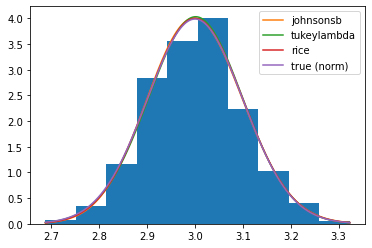

In [16]:
plt.hist(data_norm,density=True)
x = np.linspace(min(data_norm),max(data_norm),1000)
for d in distros:
    print(d)
    statobj = getattr(stats,d)
    fit = statobj.fit(data_norm)
    plt.plot(x,statobj.pdf(x,*fit),label=d)
plt.plot(x,stats.norm.pdf(x,3,.1),label='true (norm)')
plt.legend()
    

In [17]:
distros = stats_fitting.find_best_continuous_dist(data_combined,printing=False)

norminvgauss
nct
exponweib


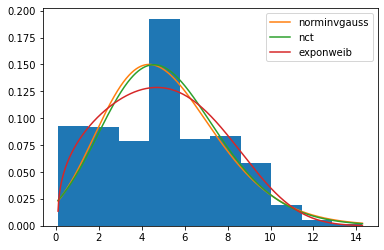

In [18]:
plt.hist(data_combined,density=True)
x = np.linspace(min(data_combined),max(data_combined),1000)
for d in distros:
    print(d)
    statobj = getattr(stats,d)
    fit = statobj.fit(data_combined)
    plt.plot(x,statobj.pdf(x,*fit),label=d)
plt.legend()    

## LL_secular

Due to the size of this package, the tutorial can be found in a separate notebook [here](./Using&#32;the&#32;Functions&#32;Module&#32;-&#32;LL_secular.ipynb).